<!--TABLE OF CONTENTS-->
Contents:
- [KNN Classifier](#KNN-Classifier)
  - [Decision boundary for KNN](#Decision-boundary-for-KNN)
  - [Tuning the number of neighbors with Grid Search](#Tuning-the-number-of-neighbors-with-Grid-Search)
  - [KNN for regression](#KNN-for-regression)
  - [Practice question](#Practice-question)
- [Clustering](#Clustering)
  - [KMeans Clustering](#KMeans-Clustering)
    - [Generating our dataset](#Generating-our-dataset)
    - [Feature Scaling](#Feature-Scaling)
    - [Conduct KMeans Clustering](#Conduct-KMeans-Clustering)
    - [Choosing K, the number of clusters](#Choosing-K,-the-number-of-clusters)
      - [Elbow Method](#Elbow-Method)
      - [Silhoutte coefficient](#Silhoutte-coefficient)
      - [Davies-Bouldin Index](#Davies-Bouldin-Index)
    - [Example of using Kmeans for color compression](#Example-of-using-Kmeans-for-color-compression)
  - [Density Based clustering](#Density-Based-clustering)
  - [Practice question](#Practice-question)
- [Comparing different clustering techniques on the face dataset](#Comparing-different-clustering-techniques-on-the-face-dataset)
  - [DBSCAN](#DBSCAN)
  - [KMeans](#KMeans)
- [Dimensionality reduction](#Dimensionality-reduction)
  - [TSNE](#TSNE)
  - [UMAP](#UMAP)
  - [Comparison of TSNE and UMAP on the digit dataset](#Comparison-of-TSNE-and-UMAP-on-the-digit-dataset)
    - [TSNE](#TSNE)
    - [UMAP](#UMAP)
  - [Practice question](#Practice-question)

# KNN Classifier

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd


KNN (K-Nearest Neighbor) is a simple supervised classification algorithm we can use to assign a class to a new data point. 
KNN does not learn an explicit model, hence it is non-parametric. It keeps all the training data to make future predictions by computing the similarity between an input data instance and each training instance.
KNN classification can be summarized as below:
- Compute the distance between the new data point and every training data point (using, for example, Euclidean distance or Manhattan distance)
- Pick K entries from the training dataset that are the closest to the new data point
- Perform the majority vote i.e., the most common class/label among those K entries will be the class of the new data point, or do weighted voting

## Decision boundary for KNN

Let's start with a simple analysis of the decision boundary using the toy dataset, created with `sklearn`'s `make_classification`.

In [7]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=101, n_features=2, n_informative=2,
                            n_redundant=0, n_repeated=0, n_classes=2,
                            n_clusters_per_class=1, class_sep=0.3, random_state=123)

Let's check how many members of each class we have:

In [9]:
Counter(y)

Counter({0: 52, 1: 49})

Note that now we will just want to analyze the impact of the number of the nearest neighbors on the boundary, so we will not do the split into the train and test dataset. We will illustrate the proper use of the KNN later on.

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay

Some parameters of `KNeighborsClassifier`:
- *n_neighbor*: Number of neighbors to use.

- *weights*: weight (combining) function used in prediction. Possible values:

    - 'uniform' : uniform weights. All points in each neighborhood are weighted equally.

    - 'distance' : weigh points by the inverse of their distance. In this case, closer neighbors of a query point will have a greater influence than the neighbors which are further away.
 
 
Let's now do `fit` of the KNN classifier with 9 neighbors and visualize the decision boundary.

In [13]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=9)

Next, we will use sklearn to visualize the predicted probability of belonging to class 1.

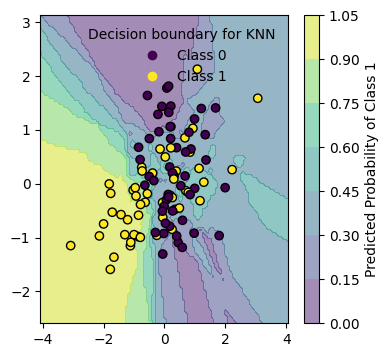

In [15]:
plt.figure(figsize=(4,4))
ax = plt.axes()
disp = DecisionBoundaryDisplay.from_estimator(knn, X, response_method="predict_proba", alpha=0.5, ax=ax)
scatter=ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
handles, labels = scatter.legend_elements()
cbar = plt.colorbar(disp.surface_, ax=ax)
cbar.set_label("Predicted Probability of Class 1")
ax.legend(handles=handles, labels=["Class 0", "Class 1"], title="Decision boundary for KNN", frameon=False)

On the plot we see that the yellow region is where the model is most certain that the points belong to class 1, and the purple region is where it is most certain that the points belong to class 0. We used `predict_proba` method to obtain class probabilities. Now use this function with `predict` method in a loop to plot the decision boundary for different values of K.

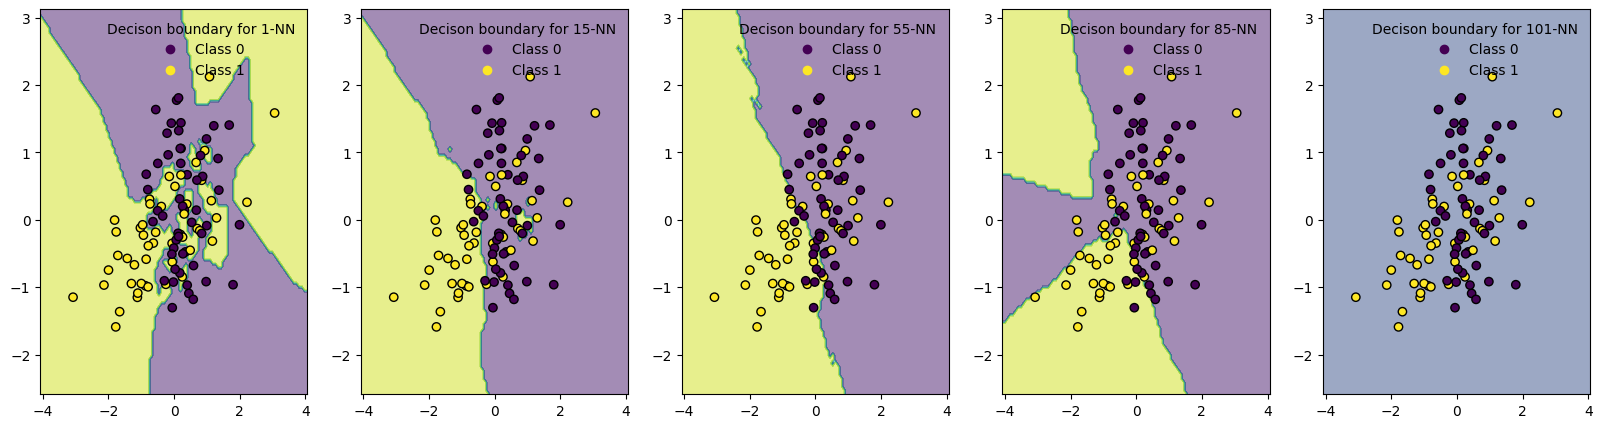

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

for k, ax in zip([1, 15, 55, 85, 101], axs):
        knn=KNeighborsClassifier(n_neighbors=k)
        knn.fit(X, y)
        disp = DecisionBoundaryDisplay.from_estimator(knn, X, response_method="predict", alpha=0.5, ax=ax)
        scatter=ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
        handles, labels = scatter.legend_elements()
        ax.legend(handles=handles, labels=["Class 0", "Class 1"], title=f"Decison boundary for {k}-NN", frameon=False)


Now, let us look at the plot we obtained. What happens to the decision boundary as K increases? As the k increases are we getting a simpler or more complex model?

What will be the prediction for any new data point for k=101? Why?

## Tuning the number of neighbors with Grid Search

We will use the breast cancer dataset and check which number of neighbors in KNN leads to best performance.

In [22]:
from sklearn.datasets import load_breast_cancer
# as_frame=True converts the data into a panda dataframe. 
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

Let's check the features with `info()` method.

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

And let's see the class distribution.

In [26]:
y.value_counts()

target
1    357
0    212
Name: count, dtype: int64

Let's check the target names

Note that in this dataset, target 0 corresponds to Malignant and 1 corresponds to Benign, while typically we would have the opposite situation, where the class of interest, here malignant class, would be denoted as class 1. 

Before we go into tuning, let's first take a small detour and visualize our features, to get some practice.

In [30]:
import seaborn as sns

Plotting histograms is straightforward with seaborn, using *histplot*. To plot different histograms for each class, we will use parameter *hue*.

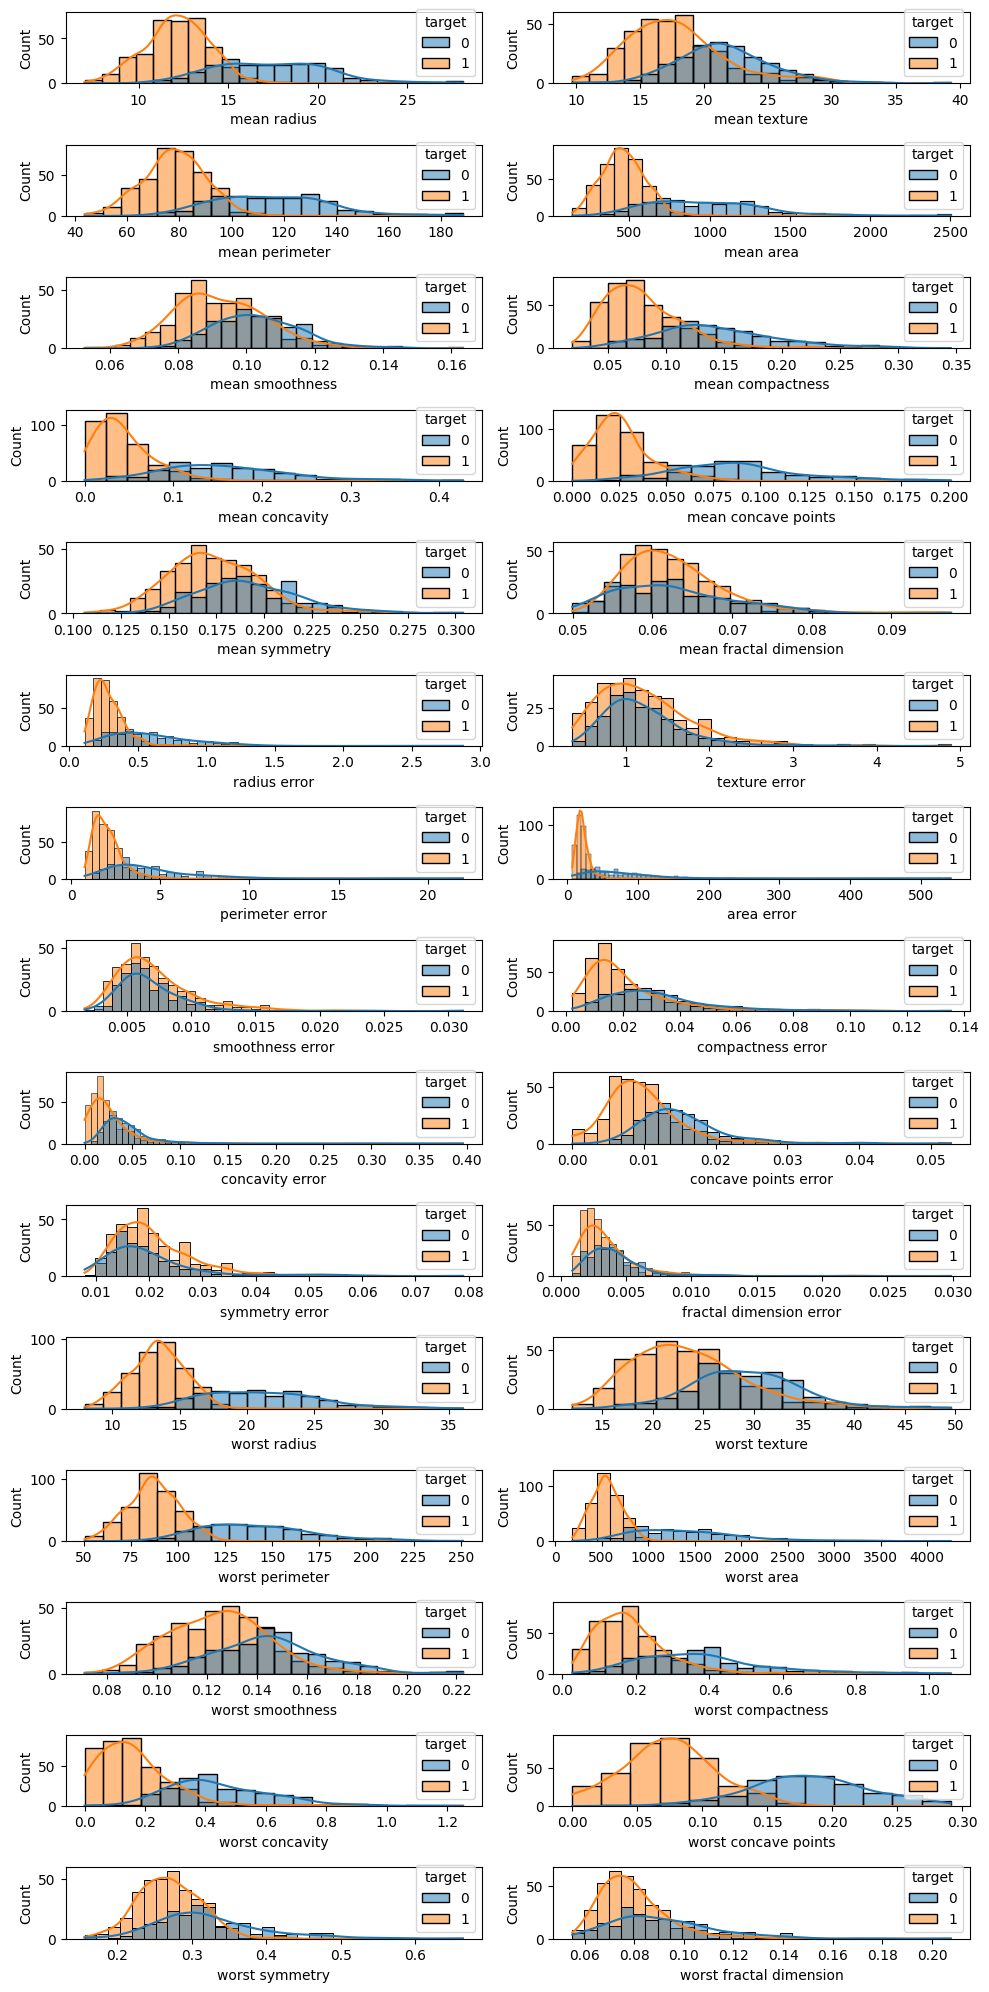

In [32]:
fig, axes = plt.subplots(nrows=int(len(X.columns)/2), ncols=2, figsize=(10, 20))
for column, ax in  zip( X.columns, axes.flat):
    sns.histplot( x=X[column], hue=y, ax=ax, kde=True)
fig.tight_layout()

Each plot overlays two histograms, one for all of the points in the benign class and one for all the points in the malignant class. This gives us some idea of how each feature is distributed across the two classes, and allows us to venture a guess as to which features are better at distinguishing malignant and benign samples. For example, the feature *smoothness error* seems quite uninformative, because the two histograms mostly overlap, while the feature *worst concave points* and *mean concave points* seems quite informative, because the histograms are quite disjoint.

Next, let's go back to our task of tuning the number of neighbors.

Let's first split our data into training and test data with 30% of the data separated for the final model evaluation.

In [35]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import  StandardScaler
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

Since KNN is a distance based method, the data must be scaled, before applying the model. We will use pipeline to glue scaling and KNN step together before the grid search.

Next, we will import `GridSearchCV`, define the search space for the number of neighbors to be from 1 to 29, choosing only odd numbers. And we will perform Cross Validation with 5 folds. Additionally, we will set the parameter `return_train_score=True`, in order to see the score on the training data, and compare it to the score on the holdout fold.

In [38]:
pipe = Pipeline( [('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors': range(1, 32,2)}
grid_search = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1, param_grid={'knn__n_neighbors': range(1, 32, 2)},
             return_train_score=True)

The default scoring metric for KNN in `sklearn` is accuracy (recall that we could have set any other metric instead using `scoring` parameter of `GridSearchCV`.) Let's see which number of neighbors gave the highest CV accuracy:

In [40]:
grid_search.best_params_

{'knn__n_neighbors': 7}

We can plot how the accuracy changed with the number of neighbors for our dataset. This plot is actually the fitting graph that we are familiar with. We will look at all the CV results using `cv_results_`.

In [42]:
results = pd.DataFrame(grid_search.cv_results_)
results.head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.015882      0.001918         0.225033        0.016135   
1       0.014655      0.003874         0.120041        0.081644   

   param_knn__n_neighbors                   params  split0_test_score  \
0                       1  {'knn__n_neighbors': 1}             0.9875   
1                       3  {'knn__n_neighbors': 3}             0.9750   

   split1_test_score  split2_test_score  split3_test_score  ...  \
0              0.900             0.9625           0.949367  ...   
1              0.925             0.9500           0.949367  ...   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.942152        0.032390               13            1.000000   
1         0.947215        0.016663                7            0.971698   

   split1_train_score  split2_train_score  split3_train_score  \
0            1.000000            1.000000            1.000000   
1            0.981132            0.968553            0.974922   

   split4_train_score  mean_train_score  std_train_score  
0            1.000000          1.000000         0.000000  
1            0.984326          0.976126         0.005843  

[2 rows x 21 columns]

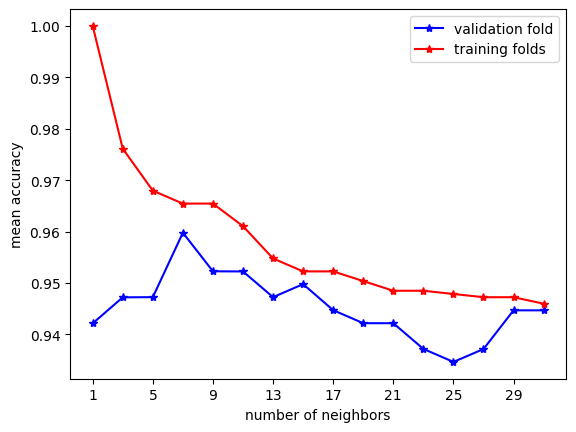

In [43]:
plt.plot(range(1, 32,2) , results['mean_test_score'], "b-*",  label="validation fold")
plt.plot(range(1, 32,2) , results['mean_train_score'], "r-*",  label="training folds")
plt.legend()
plt.xlabel("number of neighbors")
plt.ylabel("mean accuracy")
plt.xticks(range(1,30, 4));

The plot shows the mean training and holdout fold accuracy on the y-axis against the number of neighbors on the x-axis. While real-world plots are rarely very smooth, we can still
recognize some of the characteristics of overfitting and underfitting (note that
because considering fewer neighbors corresponds to a more complex model, the plot
is horizontally flipped relative to the fitting graphs we saw before).

Considering a single nearest neighbor, the prediction on the training set is perfect. But when more neighbors
are considered, the model becomes simpler and the training accuracy drops. The
holdout fold accuracy for using a single neighbor is lower than when using more neighbors,
indicating that using the single nearest neighbor leads to a model that is too
complex.

On the other hand, when considering 25 neighbors, the model is too simple and performance is even worse. The best performance is somewhere around 7 neighbors.
Still, it is good to keep the scale of the plot in mind. The worst performance is around 94% accuracy, which might still be acceptable.

Now, selecting K=7, let's evaluate our model on the test set. Recall, that by default, `GridSearchCV` refits the model using all the training data (all K folds) for the best parameters. We can access this model with `best_estimator`. Additionally, if we just want to check the default metric we can simply use the `score` method:

In [46]:
grid_search.score(X_test, y_test)

0.9766081871345029

However, we should always check the overall performance of our final model. So first we use the `predict` method to predict the classes for our test set, and then we compare the predicted values with the true values, y_test:

In [48]:
y_pred=grid_search.best_estimator_.predict(X_test)

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        68
           1       0.97      0.99      0.98       103

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.98       171
weighted avg       0.98      0.98      0.98       171



Recall that these are the values obtained using the default threshold of 0.5.

## KNN for regression

In [52]:
from sklearn.neighbors import KNeighborsRegressor

To illustrate that KNN can also be used for regression we will create a toy dataset with a single feature X and target y. We will then use this dataset to train a 5-NN Regression model, and use it to predict the values of new points. (Since it is a single feature, we do not need to scale the data.)

In [54]:
np.random.seed(0)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()
# Adding noise to targets
y[::5] += 1 * (0.5 - np.random.rand(8))

# Next we will just get 500 points from the range 0 to 5, so we can draw the prediction for these points
new_points = np.linspace(0, 5, 500)[:, np.newaxis]

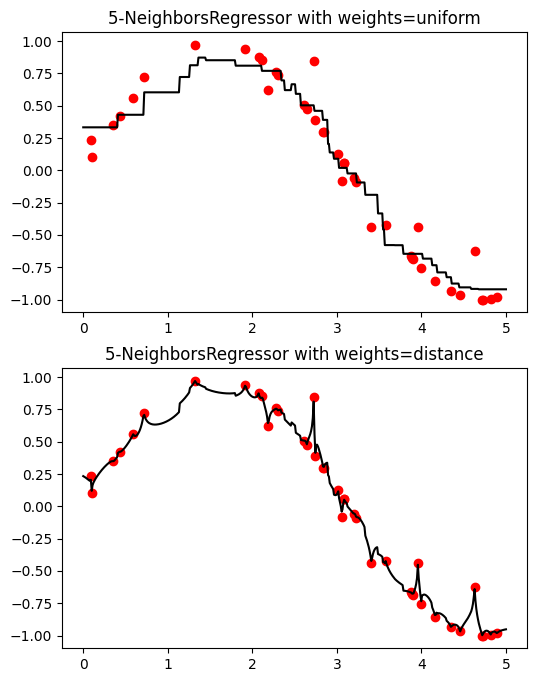

In [55]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))

for i, weights in enumerate(['uniform', 'distance']):
    knn = KNeighborsRegressor(n_neighbors=5, weights=weights)
    knn.fit(X, y)
    y_pred=knn.predict(new_points)
    axs[i].scatter(X, y, color='red', label="data")
    axs[i].plot(new_points, y_pred, color='k', label="prediction")
    axs[i].set_title(f'5-NeighborsRegressor with weights={weights}')

We can see that when the weights are based on the distance, the closest neighbor has the most influence, whereas when the weights are uniform, the prediction is smoother, as the predicted value is an average of the target values of 5 closest neighbors.

Note that we used *enumerate* function which is useful for looping through a list when we need access to both the list items and their indexes (in our case we used *i* for indexing the axes).

## Practice question
Apply KNN Classifier to the iris dataset and compare the results of using different values of K (number of neighbors)?

# Clustering

## KMeans Clustering

Some parts of this section are adapted from: https://realpython.com/k-means-clustering-python/

KMeans clustering method is an unsupervised machine learning technique used to identify clusters of data objects in a dataset. It is an example of Partitional clustering which divides data objects into non-overlapping groups. In other words, no object can be a member of more than one cluster, and every cluster must have at least one object.

Let's load a dataset for clustering using `make_blobs()` from `sklearn`, just as we did in Notebook 2.

In [64]:
from sklearn.datasets import make_blobs

### Generating our dataset

`make_blobs()` uses these parameters:

- n_samples is the total number of samples to generate.
- centers is the number of centers to generate.
- cluster_std is the standard deviation.

`make_blobs()` returns a tuple of two values:

- A two-dimensional numpy array with the x- and y-values for each of the samples
- A one-dimensional numpy array containing the cluster labels for each sample

In [66]:
features, true_labels = make_blobs(
      n_samples=200,
      centers=3,
      cluster_std=2.75,
      random_state=42 )

Let's look at the first five elements for each of the variables returned by `make_blobs()`:

In [68]:
features[:5]

array([[  9.77075874,   3.27621022],
       [ -9.71349666,  11.27451802],
       [ -6.91330582,  -9.34755911],
       [-10.86185913, -10.75063497],
       [ -8.50038027,  -4.54370383]])

In [69]:
true_labels[:5]

array([1, 0, 2, 2, 2])

In [70]:
Counter(true_labels)

Counter({1: 67, 0: 67, 2: 66})

Let's plot our dataset.
Some parameters of the scatter plot:
- c array-like or list of colors or color, which we already explained earlier. Here, we will use the cluster number as the value of this parameter to achieve that every cluster is plotted in a different color.
- s is the size of the dots in the plot

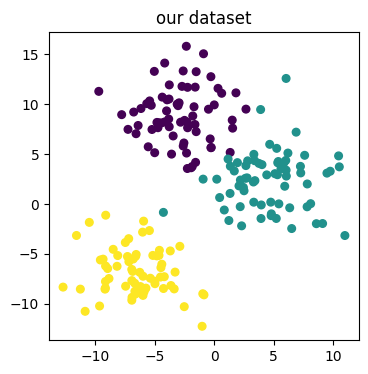

In [72]:
plt.figure(figsize=(4,4))
plt.scatter(features[:, 0], features[:, 1], s=30, c=true_labels) 
plt.title("our dataset")
plt.show()

### Feature Scaling

Data sets usually contain numerical features that have been measured in different units, such as height (in inches) and weight (in pounds). A machine learning algorithm would consider weight more important than height only because the values for weight are larger and have higher variability from person to person. However, Machine Learning algorithms need to consider all features on an even playing field. That means the values for all features must be transformed to the same scale. Feature scaling is an important data pre-processing step for most distance-based machine learning algorithms because it can have a significant impact on the performance of the algorithm. Hence, we will use the `StandardScaler` to standardize the features. 

In [75]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

Take a look at how the values have been scaled in scaled_features:

In [77]:
scaled_features[:5]

array([[ 2.13082109,  0.25604351],
       [-1.52698523,  1.41036744],
       [-1.00130152, -1.56583175],
       [-1.74256891, -1.76832509],
       [-1.29924521, -0.87253446]])

Let's plot again our clusters with the scaled data:

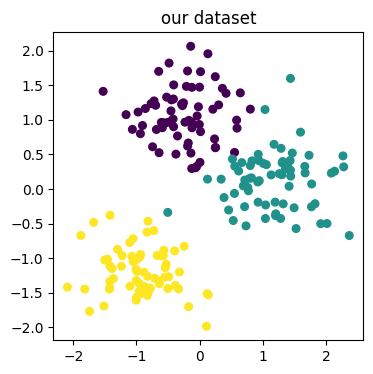

In [79]:
plt.figure(figsize=(4,4))
plt.scatter(scaled_features[:, 0],scaled_features[:, 1], s=30, c=true_labels) 
plt.title("our dataset")
plt.show()

Notice that only the scale has changed.

### Conduct KMeans Clustering

Now the data is ready to be clustered. The KMeans estimator class in `sklearn` has several parameters that can be tuned.

Here are the parameters used in this example:

- *init* controls the initialization technique. The standard version of the k-means algorithm is implemented by setting init to "k-means++" smart initialization technique.  We can also set it to "random".

- *n_clusters* sets k for the clustering step. This is the most important parameter for Kmeans.

- *n_init* sets the number of initializations to perform. This is important because two runs can converge on different cluster assignments. The default behavior for the `sklearn` algorithm when random initialization used is 10 k-means runs and it return the results of the one with the lowest  inertia or SSE (sum of the squared Euclidean distances of each point to its closest centroid), while for kmeans++ only 1 kmeans is run.

- *max_iter* sets the number of maximum iterations for each initialization of the k-means algorithm.

The difference between the traditional k-means (random) and k-means++ (default option in sklearn) lies in the initialization. Whereas k-means randomly selects the initial centroids, k-means++ behaves as follows (suppose k = 3):

1. First centroid is randomly selected;
2. For each of the remaining data points, calculate the distance between it and the nearest centroid (at the moment, there is only one from the previous step, but keep this in mind for step 4);
3. It is time to find the next centroid, and the probability of the next centroid being selected will be directly proportional to the squared distance: this denotes that points further away will have a higher probability of being selected, while points closer to the initial centroid will have a lower probability;
4. The second centroid has been selected, and now steps 2 and 3 will be repeated to find to third centroid.
5. The initialization was completed, and then the behavior will be identical to that of the traditional k-means. 

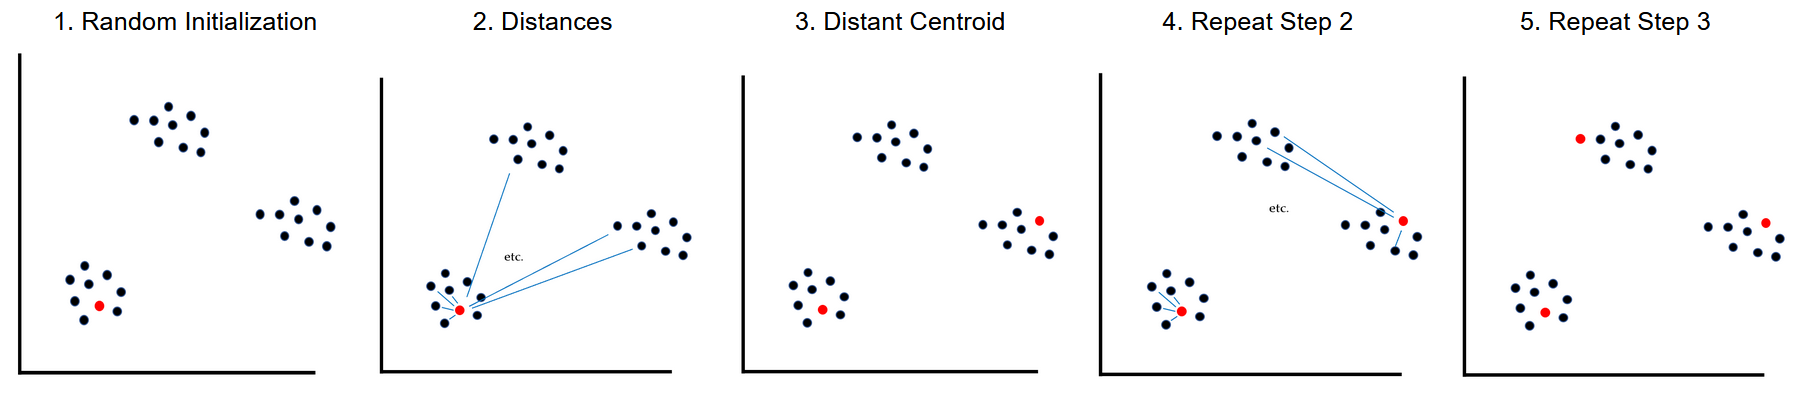

We will instantiate the KMeans class with the following arguments:

In [86]:
from sklearn.cluster import KMeans
kmeans = KMeans( 
           n_clusters=3,
           max_iter=300,
           random_state=42
 )

Now that the KMeans class is ready, the next step is to fit it to the data in scaled_features. This will perform ten runs of the KMeans algorithm on the data with a maximum of 300 iterations per run:

In [88]:
kmeans.fit(scaled_features)

KMeans(n_clusters=3, random_state=42)

Recall that after data is fitted with an estimator, parameters are estimated from the data at hand. 
All the estimated parameters are attributes of the estimator object ending by an underscore, example `cluster_centers_`.
Statistics from the initialization run with the lowest SSE (inertia) are available as attributes of KMeans after calling `fit()`:

In [90]:
# The lowest SSE value if multiple runs are used, for random initialization
kmeans.inertia_

74.57960106819854

In [91]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[ 1.19539276,  0.13158148],
       [-0.91941183, -1.18551732],
       [-0.25813925,  1.05589975]])

In [92]:
# The number of iterations required to converge
kmeans.n_iter_

6

Finally, the cluster assignments are stored as a one-dimensional numpy array in `kmeans.labels_`. Here's a look at the first five predicted labels:

In [94]:
kmeans.labels_[:5], true_labels[:5]

(array([0, 2, 1, 1, 1]), array([1, 0, 2, 2, 2]))

Note that the order of the cluster labels was flipped. The order was [1, 0, 2] in true_labels but [0,2,1] in `kmeans.labels_` even though those data objects are still members of their original clusters in `kmeans.lables_`.

This behavior is normal, as the ordering of cluster labels is dependent on the initialization. Cluster 0 from the first run could be labeled cluster 1 in the second run and vice versa. This doesn't affect clustering evaluation metrics.

Let's plot our clusters as found by the KMeans algorithm.

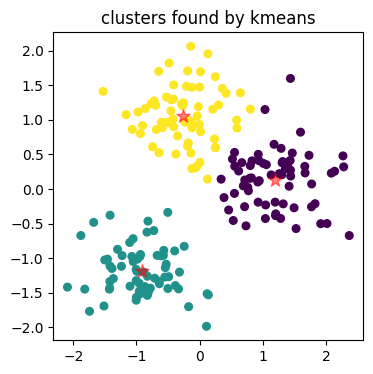

In [97]:
plt.figure(figsize=(4,4))
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], s=30, c=kmeans.labels_) 
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.5, marker='*')
plt.title("clusters found by kmeans")
plt.show();

### Choosing K, the number of clusters

Now let's look at some methods that are commonly used to evaluate the appropriate number of clusters:

- The elbow method
- The silhouette coefficient
- Davies-Bouldin index

These are often used as complementary evaluation techniques rather than one being preferred over the other. To perform the elbow method, we will run several KMeans, increment K with each iteration, and record the SSE.

#### Elbow Method

In [101]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
     kmeans = KMeans(n_clusters=k,  init= 'random', n_init= 10, max_iter=300, random_state= 42)
     kmeans.fit(scaled_features)
     sse.append(kmeans.inertia_);

Now let's plot SSE for the varying number of clusters:

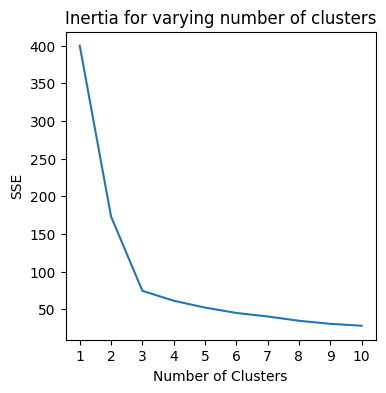

In [103]:
plt.figure(figsize=(4,4))
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Inertia for varying number of clusters')
plt.show()

Notice that SSE continues to decrease as we increase k. As more centroids are added, the distance from each point to its closest centroid will decrease.

There's a sweet spot where the SSE curve starts to bend known as the *elbow* point. The x-value of this point is thought to be a reasonable trade-off between error and number of clusters. In this example, the elbow is located at k=3.

Determining the elbow point in the SSE curve is not always straightforward, especially with real world data.

#### Silhoutte coefficient

The Silhouette coefficient is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:

- How close the data point is to other points in the cluster
- How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In the `sklearn` implementation of the silhouette coefficient, the average Silhouette coefficient of all the samples is summarized into one score. Let's loop through values of K again. This time, instead of computing SSE, we compute the Silhouette coefficient.

In [108]:
from sklearn.metrics import silhouette_score
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient, because it raises an error for 1 cluster
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, max_iter=300, random_state= 42)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score);

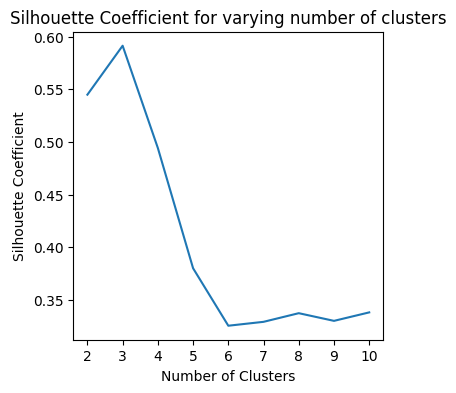

In [109]:
plt.figure(figsize=(4,4))
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title('Silhouette Coefficient for varying number of clusters')
plt.show()

Plotting the average Silhouette scores for each K shows that the best choice for k is 3 since it has the maximum score.

#### Davies-Bouldin Index

Now let's calculate Davies-Bouldin Index whose the values range from 0 and 1, with lower values being denoting more separation between clusters.

In [113]:
from sklearn.metrics import davies_bouldin_score
# A list holds the DB score for each k
DB_score = []


for k in range(2, 11):
    kmeans = KMeans(n_clusters=k,  init= 'random', n_init= 10, max_iter=300, random_state= 42)
    kmeans.fit(scaled_features)
    score = davies_bouldin_score(scaled_features, kmeans.labels_)
    DB_score.append(score)

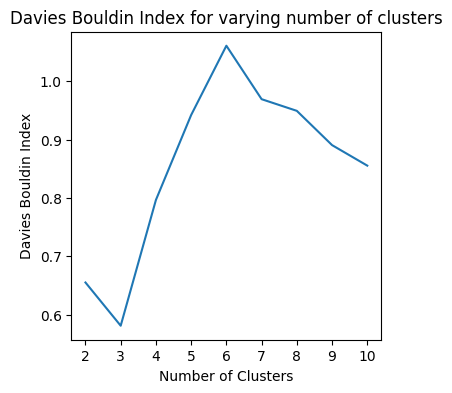

In [114]:
plt.figure(figsize=(4,4))
plt.plot(range(2, 11), DB_score)
plt.xticks(range(2, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('Davies Bouldin Index')
plt.title('Davies Bouldin Index for varying number of clusters')
plt.show()

A lower Davies-Bouldin index relates to a model with better separation between the clusters, so again 3 clusters seems the best choice.

Ultimately, the decision on the number of clusters to use should be guided by a combination of domain knowledge and clustering evaluation metrics. For real world datasets, the maximum of Silhouette index might not exactly coincide with the minimum of DB Index, nor with the elbow point, hence, the goal is to choose a value of K that balances the metrics: higher Silhouette score, lower DB index.

### Example of using Kmeans for color compression

The example is from: https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

One interesting application of clustering is color compression within images. For example, we can have an image with millions of colors. In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Let's consider the image shown in the following figure, which is from the `sklearn` datasets module.

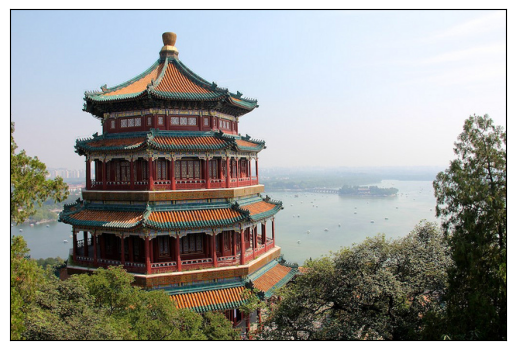

In [120]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

Each pixel in an RGB image is typically represented by a 3-tuple of values (RGB) representing the intensity of red, green, or blue light present in the image. The intensity of each color at each pixel is typically represented by a value in the range of 0 to 255, where 0 indicates no presence of the color and 255 indicates the maximum presence of that color.

The image itself is stored in a three-dimensional array of size (height, width, RGB). 

In [122]:
china.shape

(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space. We will reshape the data to [n_samples x n_pixels], and rescale the colors so that they lie between 0 and 1:

In [124]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

Now, each data point represents a pixel, and has 3 features: value of red, green and blue. These values could be from a range 0 to 255, but now they are scaled between 0 and 1. 

Using three bytes per pixel in a display system (eight bits for each red, green and blue subpixel), each of the color has 256 color shades from 0 to 255 so in total is $256*256*256$=16,777,216 colors that can be represented in the color palette.

Now let's reduce these 16 million colors to just 16 colors, using a KMeans clustering across the pixel space. We will perform the clustering into 16 clusters, to find 16 centroids. And then, each data point will be represented as the centroid it is the closest to. Hence, instead of having any value of color, each data point will have one of 16 possible values, therefore, representing the image with only 16 colors.

In [126]:
kmeans = KMeans(n_clusters=16)
kmeans.fit(data)

KMeans(n_clusters=16)

KMeans is unsupervised method, but it still has `predict` method which predicts the closest cluster each sample in data belongs to.

In [128]:
closest_clusters=kmeans.predict(data)

In [129]:
new_colors = kmeans.cluster_centers_[closest_clusters]

In the cell above new color is basically replacing the value of each data point by the value of the cluster center it is closest to.

(-0.5, 639.5, 426.5, -0.5)

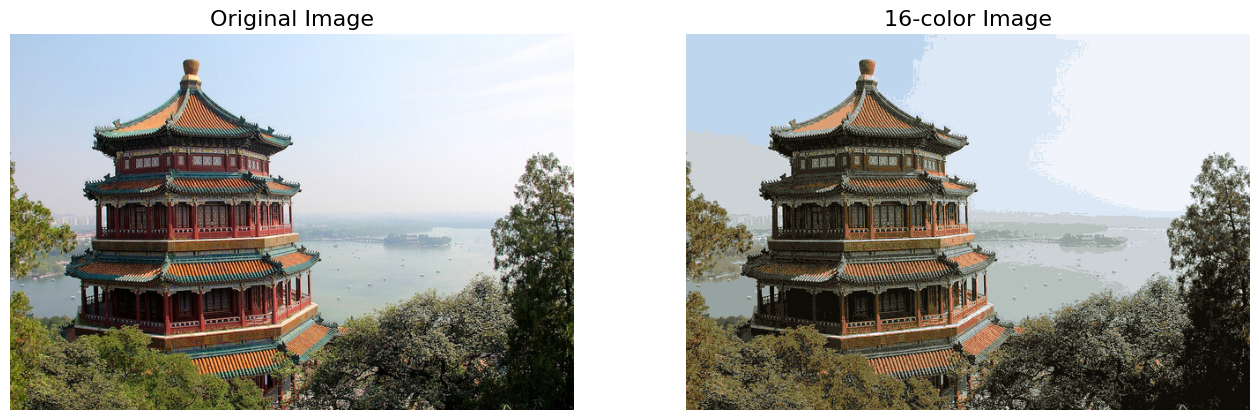

In [131]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[0].axis('off')                   
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16)
ax[1].axis('off')

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable. This image on the right achieves a compression factor of around 1 million! While this is an interesting application of kmeans, there are certainly better way to compress information in images. 

## Density Based clustering

Density-based clustering determines cluster assignments based on the density of data points in a region. 
Clusters are assigned where there are high densities of data points separated by low-density regions.

Unlike the other clustering categories, this approach doesn't require the user to specify the number of clusters. 
Instead, there is a distance-based parameter that acts as a tunable threshold. This threshold determines how close points must be to be considered a cluster member. Examples of density-based clustering algorithms include DBSCAN.

In [135]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

Let's generate synthetic data in the shape of crescents using `make_moons`.
`make_moons()` uses these parameters:

- *n_samples* is the total number of samples to generate 
- *noise* is the standard deviation of Gaussian noise added to the data.

`make_moons(`) returns a tuple of two values:

- A two-dimensional numpy array with the x- and y-values for each of the samples
- A one-dimensional numpy array containing the cluster labels for each sample

After generating the data, we again need to scale it.

In [137]:
features, true_labels = make_moons(n_samples=250, noise=0.05, random_state=42 )
scaled_features = scaler.fit_transform(features)

Let's visualize our data:

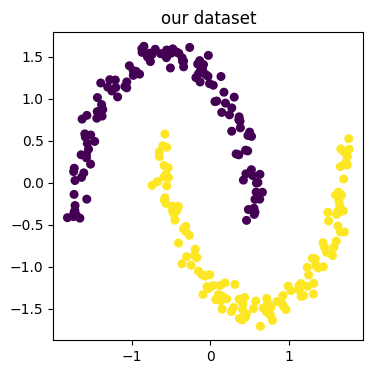

In [139]:
plt.figure(figsize=(4,4))
plt.scatter(scaled_features[:, 0],scaled_features[:, 1], s=30, c=true_labels) 
plt.title("our dataset")
plt.show()

Now the data are ready to be clustered. The DBSCAN estimator class in `sklearn` is flexible, providing several parameters that can be tuned.

Here are some of the parameters:

- *eps*, default=0.5 : The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is the most important DBSCAN parameter to choose appropriately for the data set and distance function.

- *min_samples*, default=5: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

- *metric* , default=’euclidean’

Instantiate the DBSCAN class with the following arguments:

In [141]:
dbscan = DBSCAN(eps=0.3)
dbscan.fit(scaled_features)

DBSCAN(eps=0.3)

Let's check the labels of the first few points using `labels_` attribute which gives cluster labels for each point in the dataset given to `fit()`. Noisy samples are given the label -1.

In [143]:
dbscan.labels_[:5]

array([0, 1, 1, 1, 1], dtype=int64)

Let's see what clusters were found:

In [145]:
Counter(dbscan.labels_)

Counter({0: 125, 1: 125})

Let's plot clusters found by DBSCAN

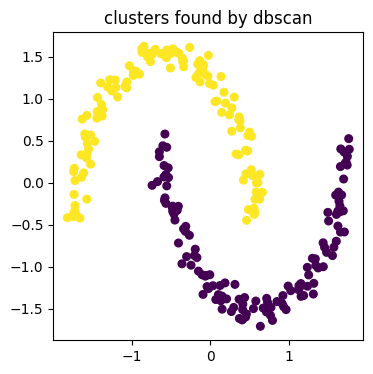

In [147]:
plt.figure(figsize=(4,4))
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], s=30, c=dbscan.labels_) 
plt.title("clusters found by dbscan")
plt.show()

Now, we can compare with KMeans.

In [149]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(scaled_features)

KMeans(n_clusters=2)

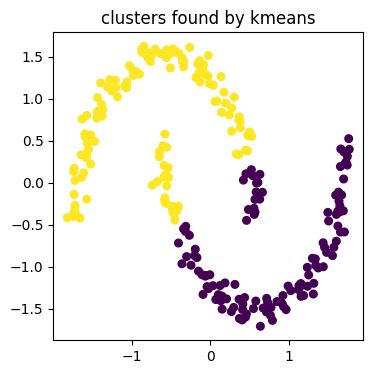

In [150]:
plt.figure(figsize=(4,4))
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], s=30, c=kmeans.labels_) 
plt.title("clusters found by kmeans")
plt.show()

As mentioned earlier, KMeans work well only if clusters have spherical shapes.

## Practice question

Import the iris dataset, and test several clustering tecniques with varying number of clusters. Evaluate the results using the metrics we discussed. What number of clusters would you choose?
Note: Do not use the `iris.target` when you do the clustering.

# Comparing different clustering techniques on the face dataset

This part of the notebook is adapted from Chapter 3 of the book *Introduction to Machine Learning*, by Andreas C. Müller & Sarah Guido.

This section is to illustrate performance of different clustering methods. No need to enter into the details of visualizing the faces.

We will do a comparison of different clustering approaches using a dataset with face images. This dataset contains face images of celebrities downloaded from the Internet, and it includes faces of politicians, singers, actors, and athletes from the early 2000s. We will use grayscale versions of these images, and scale them down for faster processing.

In [155]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

In [156]:
print('people.images.shape', people.images.shape)
print('Number of classes', len(people.target_names))

people.images.shape (3023, 87, 65)
Number of classes 62


There are 3,023 images, each 87×65 pixels large, belonging to 62 different people:


Let's look at some examples: 

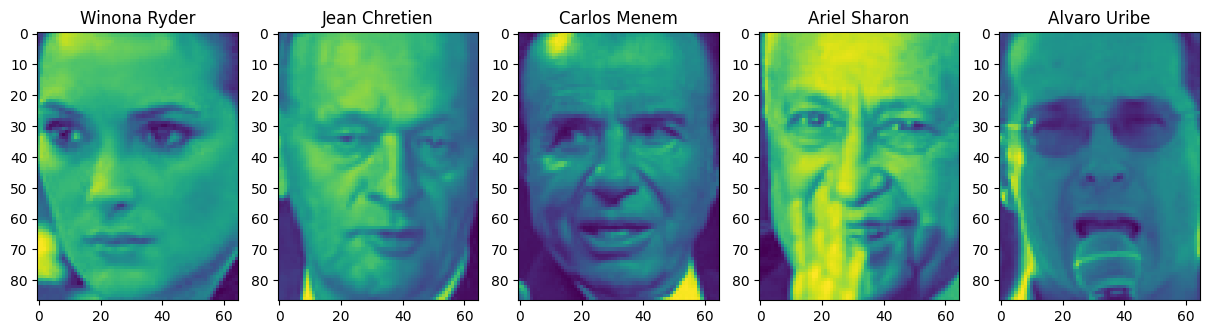

In [159]:
fix, axes = plt.subplots(1, 5, figsize=(15, 8))
for target, image, ax in zip(people.target, people.images, axes):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In the code above, zip function allows us to access an image, its target and the index of a subplot in each loop iteration. If `zip` is given iterables of different lengths, the resulting combination will only be as long as the smallest iterable passed, which in this case was 5.

Next, we will choose 50 image of each person, to have a balanced dataset.

In [162]:
mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
X_people = people.data[mask]
y_people = people.target[mask]
# scale the grayscale values to be between 0 and 1
X_people = X_people / X_people.max()

While we will not go into the details of the code above, it's worth noting the use of the concept of masking which is useful in general. We can use Boolean arrays as masks, to select particular subsets of the data. We get the Boolean array in the example above as the result of the comparison *people.target == target*, where *people.target* is an array and *target* is some value of target (it changes each time in the loop). Now, we create an array, we called it *mask*, which is an array with values True for those values in *people.target* that equal *target* and False for all the other array entries. Next, when we use *mask* to index the array *people.data* what is returned is an array with entries in positions at which the mask array is True, i.e., filled with all the values that meet the condition *people.target == target*.

More detailed explanation of the concept of masking can be found in: https://jakevdp.github.io/PythonDataScienceHandbook/02.06-boolean-arrays-and-masks.html

## DBSCAN

In [165]:
dbscan = DBSCAN()
dbscan.fit(X_people)
Counter(dbscan.labels_)

Counter({-1: 2063})

We see that all the returned labels are –1, so all of the data was labeled as “noise” by
DBSCAN. There are two things we can change to help this: we can make eps higher,
to expand the neighborhood of each point, and set min_samples lower, to consider
smaller groups of points as clusters. Let’s try changing min_samples first. Note its default value is 5 (this includes the point itself):

In [167]:
dbscan = DBSCAN(min_samples=3)
dbscan.fit(X_people)
Counter(dbscan.labels_)

Counter({-1: 2063})

Even when considering groups of three points, everything is labeled as noise. So, we
need to increase eps, whose default value is 0.5:

In [169]:
dbscan = DBSCAN(min_samples=3, eps=15)
dbscan.fit(X_people)
Counter(dbscan.labels_)

Counter({0: 2052, -1: 11})

Using a much larger eps of 15, we get only a single cluster and noise points. We can
use this result to find out what the “noise” looks like compared to the rest of the data.
There are very few noise points—only 11—so we can look at all of them:

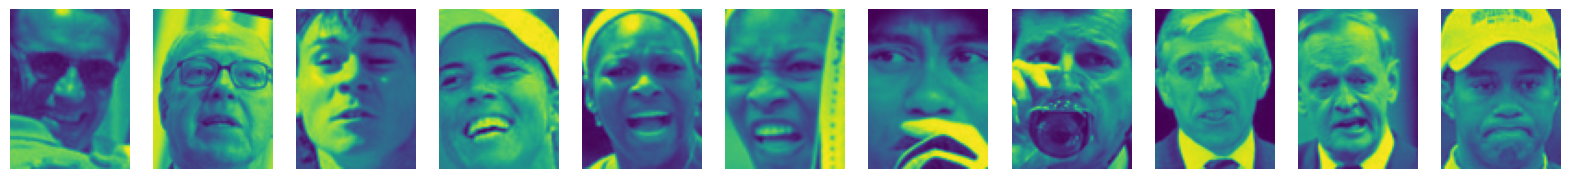

In [171]:
image_shape = people.images[0].shape
noise = X_people[dbscan.labels_==-1]
fig, axes = plt.subplots(1, 11, figsize=(20, 3))
for image, ax in zip(noise, axes):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
    ax.axis('off') 

Comparing these images to the random sample of face images seen, we
can guess why they were labeled as noise: there are people
drinking from a glass,   wearing hats, and having a hand in front of the face. The other images contain odd angles
or crops that are too close or too wide.


If we want to find more interesting clusters than just one large one, we need to set eps
smaller, somewhere between 15 and 0.5 (the default). Let’s have a look at what different
values of eps result in:

In [173]:
for eps in [1, 3, 5, 7, 8, 9, 11, 13]:
    print('eps=', eps)
    dbscan = DBSCAN(eps=eps, min_samples=3)
    dbscan.fit(X_people)
    print(Counter(dbscan.labels_))

eps= 1
Counter({-1: 2063})
eps= 3
Counter({-1: 2063})
eps= 5
Counter({-1: 2063})
eps= 7
Counter({-1: 1991, 1: 41, 0: 8, 3: 6, 5: 5, 4: 3, 2: 3, 6: 3, 7: 3})
eps= 8
Counter({-1: 1738, 0: 319, 2: 3, 1: 3})
eps= 9
Counter({-1: 1299, 0: 752, 1: 3, 2: 3, 3: 3, 4: 3})
eps= 11
Counter({0: 1650, -1: 410, 1: 3})
eps= 13
Counter({0: 1964, -1: 99})


For low settings of eps, all points are labeled as noise. For eps=7, we get many noise
points and many smaller clusters. For eps=9 we still get many noise points, but we get
one big cluster and some smaller clusters. Starting from eps=13, we get only one large
cluster and noise.


The results for eps=7 look most interesting, with many small clusters. We can investigate
this clustering in more detail by visualizing all of the points in each of the 6 smaller clusters.

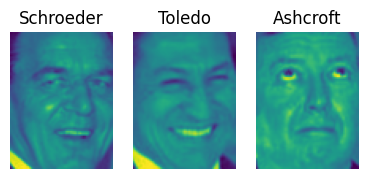

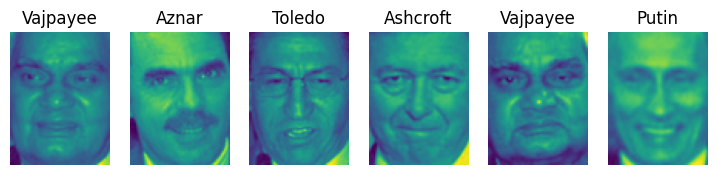

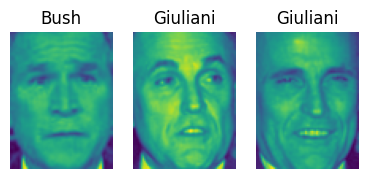

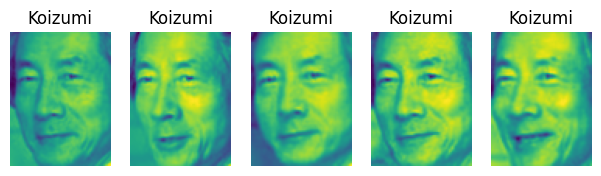

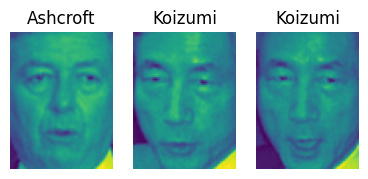

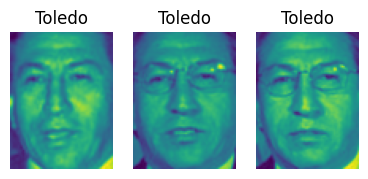

In [175]:
dbscan = DBSCAN(min_samples=3, eps=7)
dbscan.fit(X_people)
for cluster in range(2, max(dbscan.labels_) + 1):
    mask = dbscan.labels_ == cluster
    n_images = np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4))
    for image, label, ax in zip(X_people[mask], y_people[mask], axes):
        ax.imshow(image.reshape(image_shape))
        ax.set_title(people.target_names[label].split()[-1])
        ax.axis('off') 

Some of the clusters correspond to people with very distinct faces (within this dataset),
such as Koizumi. Within each cluster, the orientation of the face is also quite fixed, as well as the facial expression. Some of the clusters contain faces of multiple
people, but they share a similar orientation and expression.

## KMeans

We saw that it was not possible to create
more than one big cluster using DBSCAN. KMeans is much more likely to create clusters of even size, but we do need to set a target number
of clusters. We could set the number of clusters to the known number of people in
the dataset, instead, we can start with a low number of clusters, like 10, which
might allow us to analyze each of the clusters:


In [179]:
km = KMeans(n_clusters=10, random_state=0)
km.fit(X_people)
Counter(km.labels_)

Counter({0: 301,
         1: 240,
         4: 221,
         9: 218,
         5: 204,
         6: 200,
         8: 190,
         7: 184,
         2: 158,
         3: 147})

As we can see, KMeans clustering partitioned the data into relatively similarly sized clusters from 147 to 301. This is quite different from the result of DBSCAN. We can further analyze the outcome of KMeans by visualizing the cluster centers:

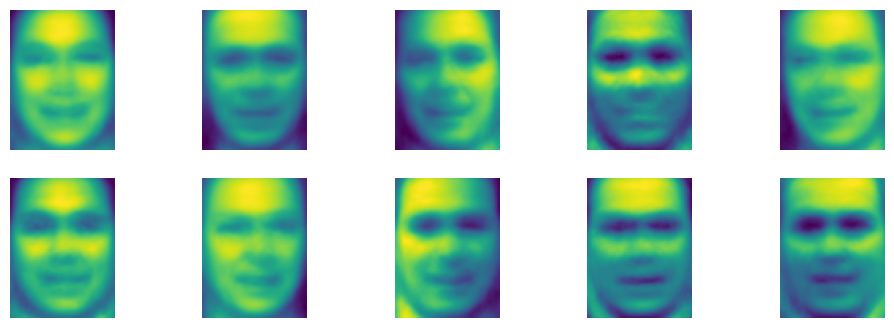

In [181]:
fig, axes = plt.subplots(2, 5, figsize=(12, 4))
for center, ax in zip(km.cluster_centers_, axes.flat):
    ax.imshow(center.reshape(image_shape))
    ax.axis('off')

The cluster centers found by KMeans are very smooth versions of faces. This is not very surprising, given that each center is an average of 147 to 301 face images.  The clustering seems to pick up on different orientations of the face and different expressions.

# Dimensionality reduction

## TSNE

There is a class of algorithms for visualization called manifold learning algorithms that allow us to visualize high dimesnional data. A particularly useful one is the TSNE algorithm.

Manifold learning algorithms are mainly aimed at visualization, and so are rarely used to generate more than two new features. Some of them, including TSNE, compute a new representation of the training data, but don't allow transformations of new data. This means these algorithms cannot be applied to a test set: rather, they can only transform the data they were trained for. Manifold learning can be useful for exploratory data analysis, but is rarely used if the final goal is supervised learning. The idea behind TSNE is to find a two-dimensional representation of the data that preserves the distances between points as best as possible. TSNE starts with a random two-dimensional representation for each data point, and then tries to make points that are close in the original feature space closer, and points that are far apart in the original feature space farther apart. TSNE puts more emphasis on points that are close by, rather than preserving distances between far-apart points. In other words, it tries to preserve the information indicating which points are neighbors to each other.

Let's now generate some data using *make_swiss_roll* and visualize it using TSNE. Note that for TSNE, we must use `fit_transform` instead of `fit`, as TSNE has no `transform` method.

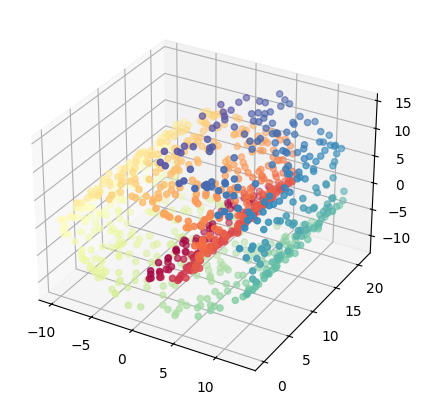

In [185]:
from sklearn.datasets import make_swiss_roll
X, color = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot( projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
plt.show()

In [186]:
X[:, 0].shape

(1000,)

In [187]:
color.shape

(1000,)

In [188]:
X_scaled = scaler.fit_transform(X)

In [189]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42,  perplexity = 10)
# use fit_transform instead of fit, as TSNE has no transform method
X_tsne = tsne.fit_transform(X_scaled)
print('Original shape: ', str(X_scaled.shape))
print('Reduced shape: ', str(X_tsne.shape))

Original shape:  (1000, 3)
Reduced shape:  (1000, 2)


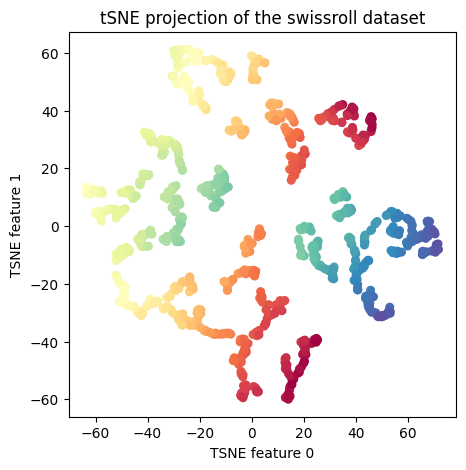

In [190]:
plt.figure(figsize=(5, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],  s=30, c=color , cmap=plt.cm.Spectral)
plt.xlabel('TSNE feature 0')
plt.ylabel('TSNE feature 1')
plt.title('tSNE projection of the swissroll dataset');

One of the parameters of TSNE is *perplexity*. It says (loosely) how to balance attention between local and global aspects of the data. The parameter is, in a sense, a guess about the number of close neighbors each point has. 
Larger datasets usually require a larger perplexity. 
Typical values are between 5 and 50. Different values can result in significantly different results.
We should try changing the value to see its impact. 

Note that TSNE is based on distance calculation, hence, we need to scale the data to ensure that all features contribute equally to the distance computations.

## UMAP

Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualization similarly to TSNE, but also for general non-linear dimension reduction.

To use Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP), you should first install the library (in the virtual environment that you use for this class): \
`pip install umap-learn`

In [194]:
import umap.umap_ as UMAP

C:\ProgramData\anaconda3\envs\ml2025\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [195]:
reducer = UMAP.UMAP()
embedding = reducer.fit_transform(X_scaled)
embedding.shape

C:\ProgramData\anaconda3\envs\ml2025\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(1000, 2)

Just like for TSNE, data needs to be scaled before applying UMAP.

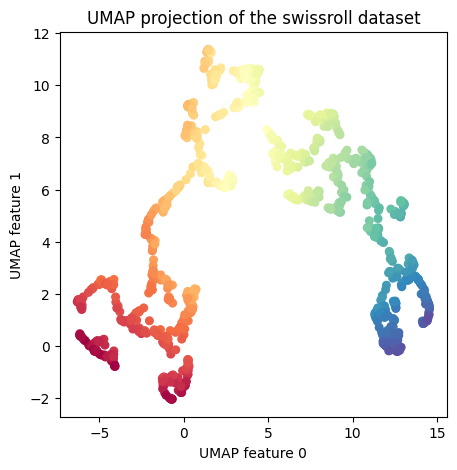

In [197]:
plt.figure(figsize=(5, 5))
plt.scatter(embedding[:, 0],embedding[:, 1],  s=30, c=color , cmap=plt.cm.Spectral)
plt.xlabel('UMAP feature 0')
plt.ylabel('UMAP feature 1')
plt.title('UMAP projection of the swissroll dataset');

## Comparison of TSNE and UMAP on the digit dataset  

We will apply both algorithms to visualize a dataset of handwritten digits that is included in `sklearn`. Each data point in this dataset is an 8×8 grayscale image of a handwritten digit 0 to 9, and each element is an integer in the range 0-16. Since all the features are on the same scale, we do not need to apply scaling. Let's see an example image for each class:

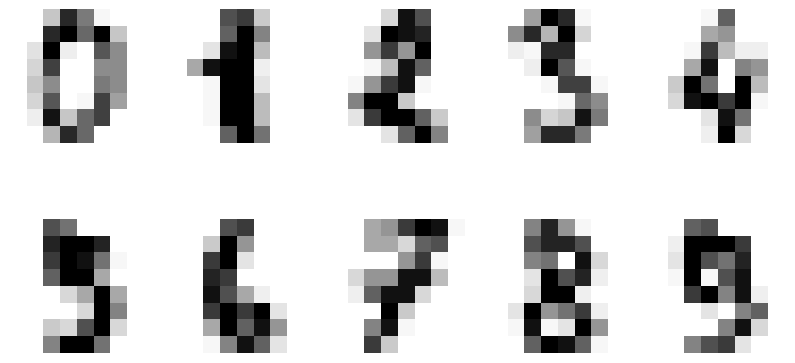

In [200]:
from sklearn.datasets import load_digits
digits = load_digits()
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for ax, img in zip(axs.flat, digits.images):
    ax.imshow(img, cmap='Greys')
    ax.axis('off')

Note that the digits.data attribute lets us access a tabular version of this dataset where the examples
are represented by the rows, and the columns correspond to the pixels:

In [202]:
digits.data.shape

(1797, 64)

We have 1797 images and 64 features (8x8 pixels). Let's check how many images per each digit do we have:

In [204]:
Counter(digits.target)

Counter({3: 183,
         1: 182,
         5: 182,
         4: 181,
         6: 181,
         9: 180,
         7: 179,
         0: 178,
         2: 177,
         8: 174})

In [205]:
import matplotlib.patheffects as PathEffects

In [206]:
X=digits.data
y=digits.target

### TSNE

Let’s apply TSNE to the same dataset, and compare the results. We will try several different values of perplexity parameter.

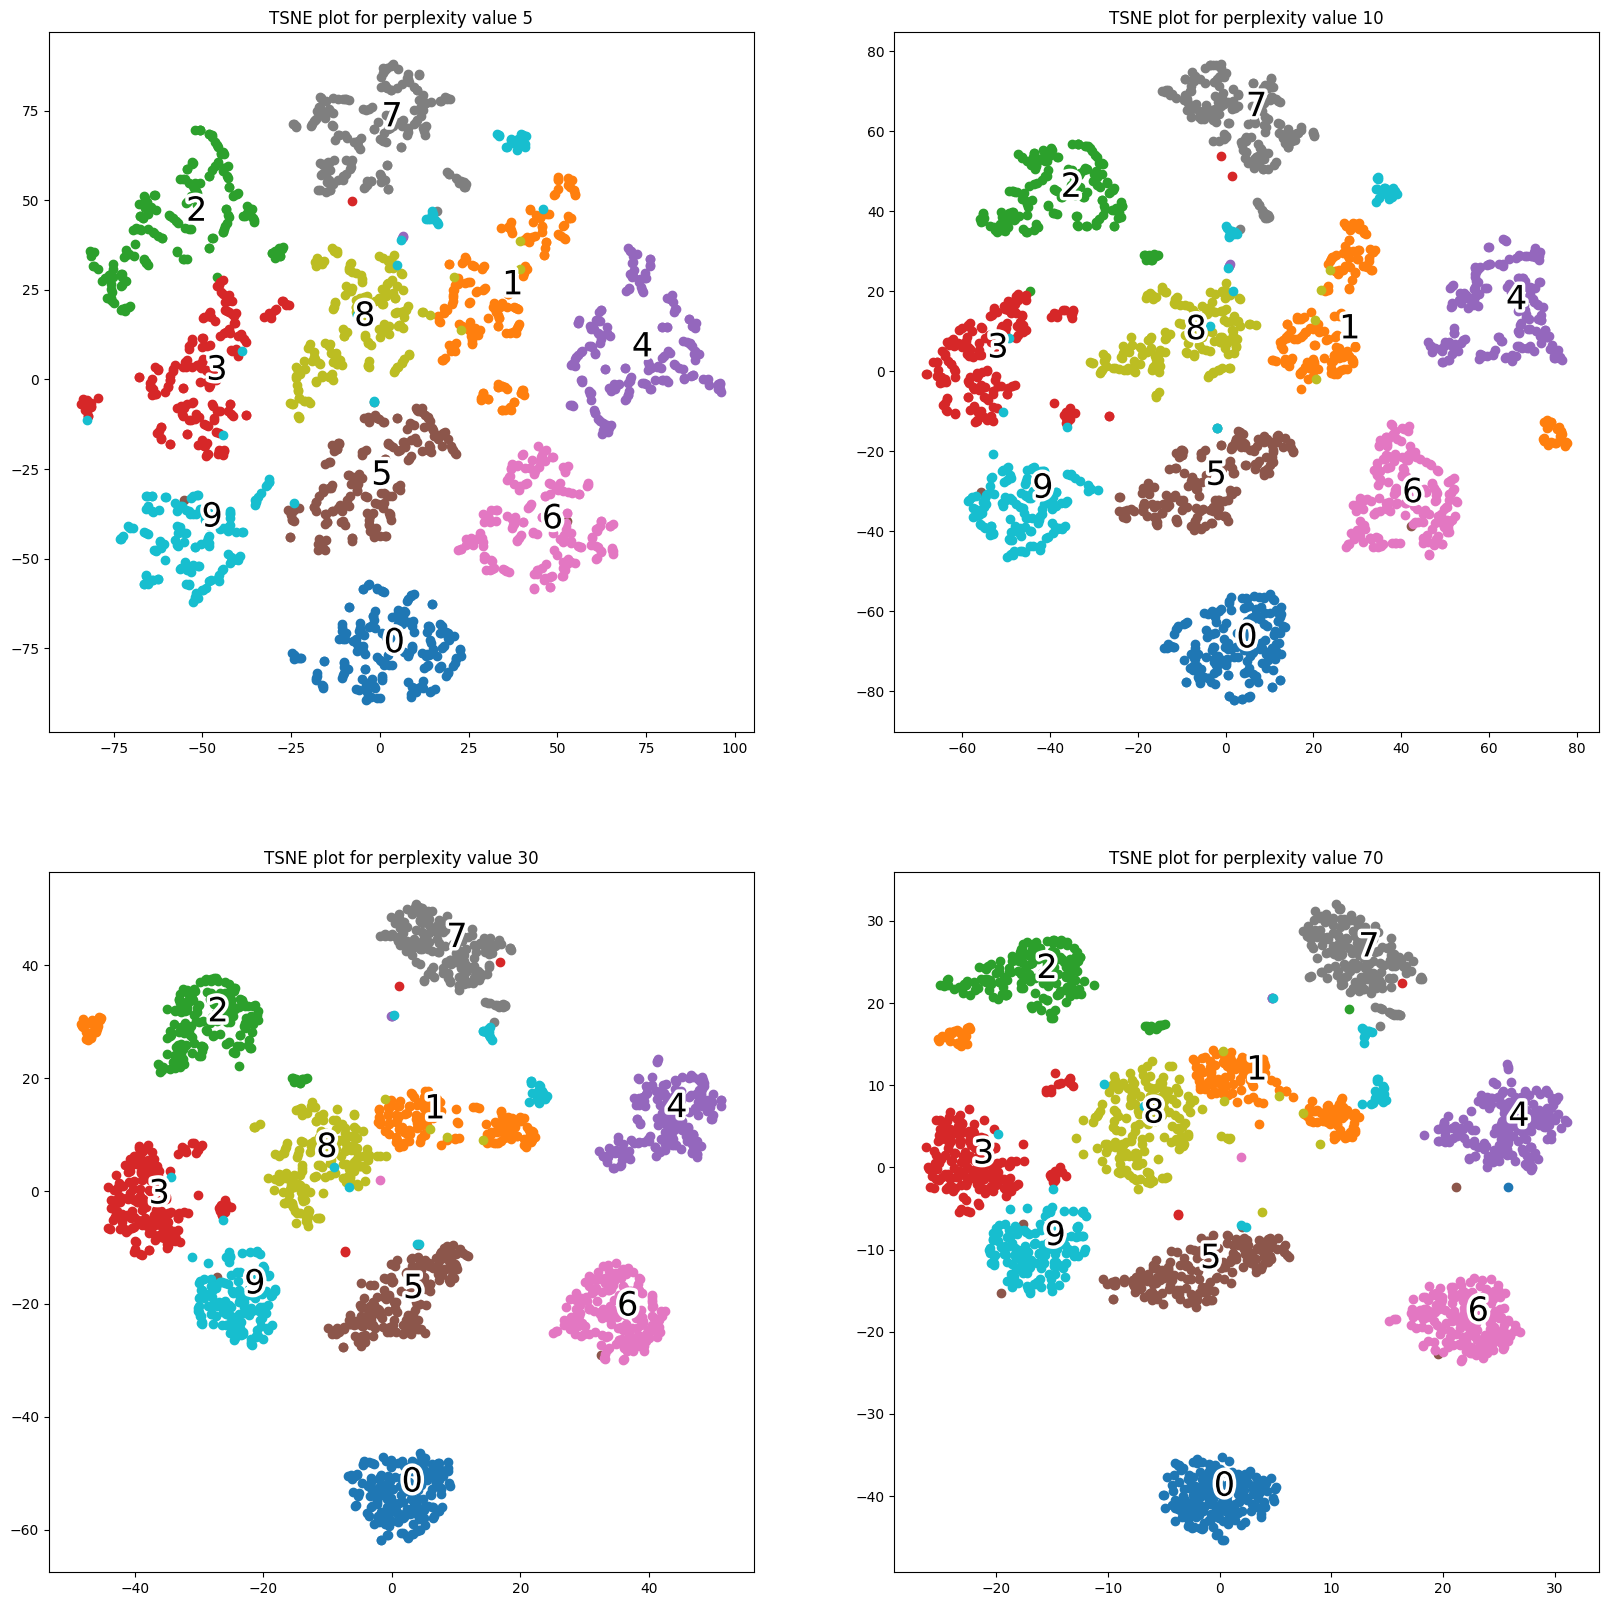

In [209]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for perplexity_value, ax in zip( [5, 10, 30, 70], axes.flat): 
    tsne = TSNE(random_state=42, perplexity=perplexity_value)
    X_tsne = tsne.fit_transform(digits.data)
    for i in range(10):
        ax.scatter(X_tsne[y == i, 0], X_tsne[y == i, 1])
        xtext, ytext = np.median(X_tsne[y == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
    ax.set_title(f'TSNE plot for perplexity value {perplexity_value}')

In this case, we see that the perplexity does not change much the results. All the classes are quite clearly separated in all the plots. The ones (orange) and nines (light blue) are somewhat split up, but most of the classes form a single dense group. TSNE has no knowledge of the class labels: it is completely unsupervised. Still, it can find a representation of the data in two dimensions that clearly separates the classes, based solely on how close points are in the original space.

Matplotlib's *PathEffects* are used for visual purposes, such that the class label is displayed in the center (via np.median) of data points belonging to each respective digit. With np.median we specified axis=0, meaning the median is found across the rows, or across datapoints of the same target value. The path effects first create a white outline around the text with a specified thickness, enhancing its visibility against complex backgrounds, and then ensure that the text inside the outline is rendered in its standard form.

### UMAP

Now let's apply UMAP, for different values of the hyperparameters:
- *n_neighbors*: controls how UMAP balances local versus global structure in the data, default value is 15
- *min_dist*: controls how tightly UMAP is allowed to pack points together, default value is 0.1. 

We will test 2 different values of *n_neighbors* (5,  50) and 2 values for *min_dist* (0.1, 0.3). The code below just allows us to create a list of 4 possible combinations:

In [215]:
import itertools
combinations=[i for i in itertools.product([5, 50], [0.1, 0.5])]
combinations

[(5, 0.1), (5, 0.5), (50, 0.1), (50, 0.5)]

Now let's plot UMAP:

C:\ProgramData\anaconda3\envs\ml2025\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\anaconda3\envs\ml2025\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\anaconda3\envs\ml2025\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\ProgramData\anaconda3\envs\ml2025\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


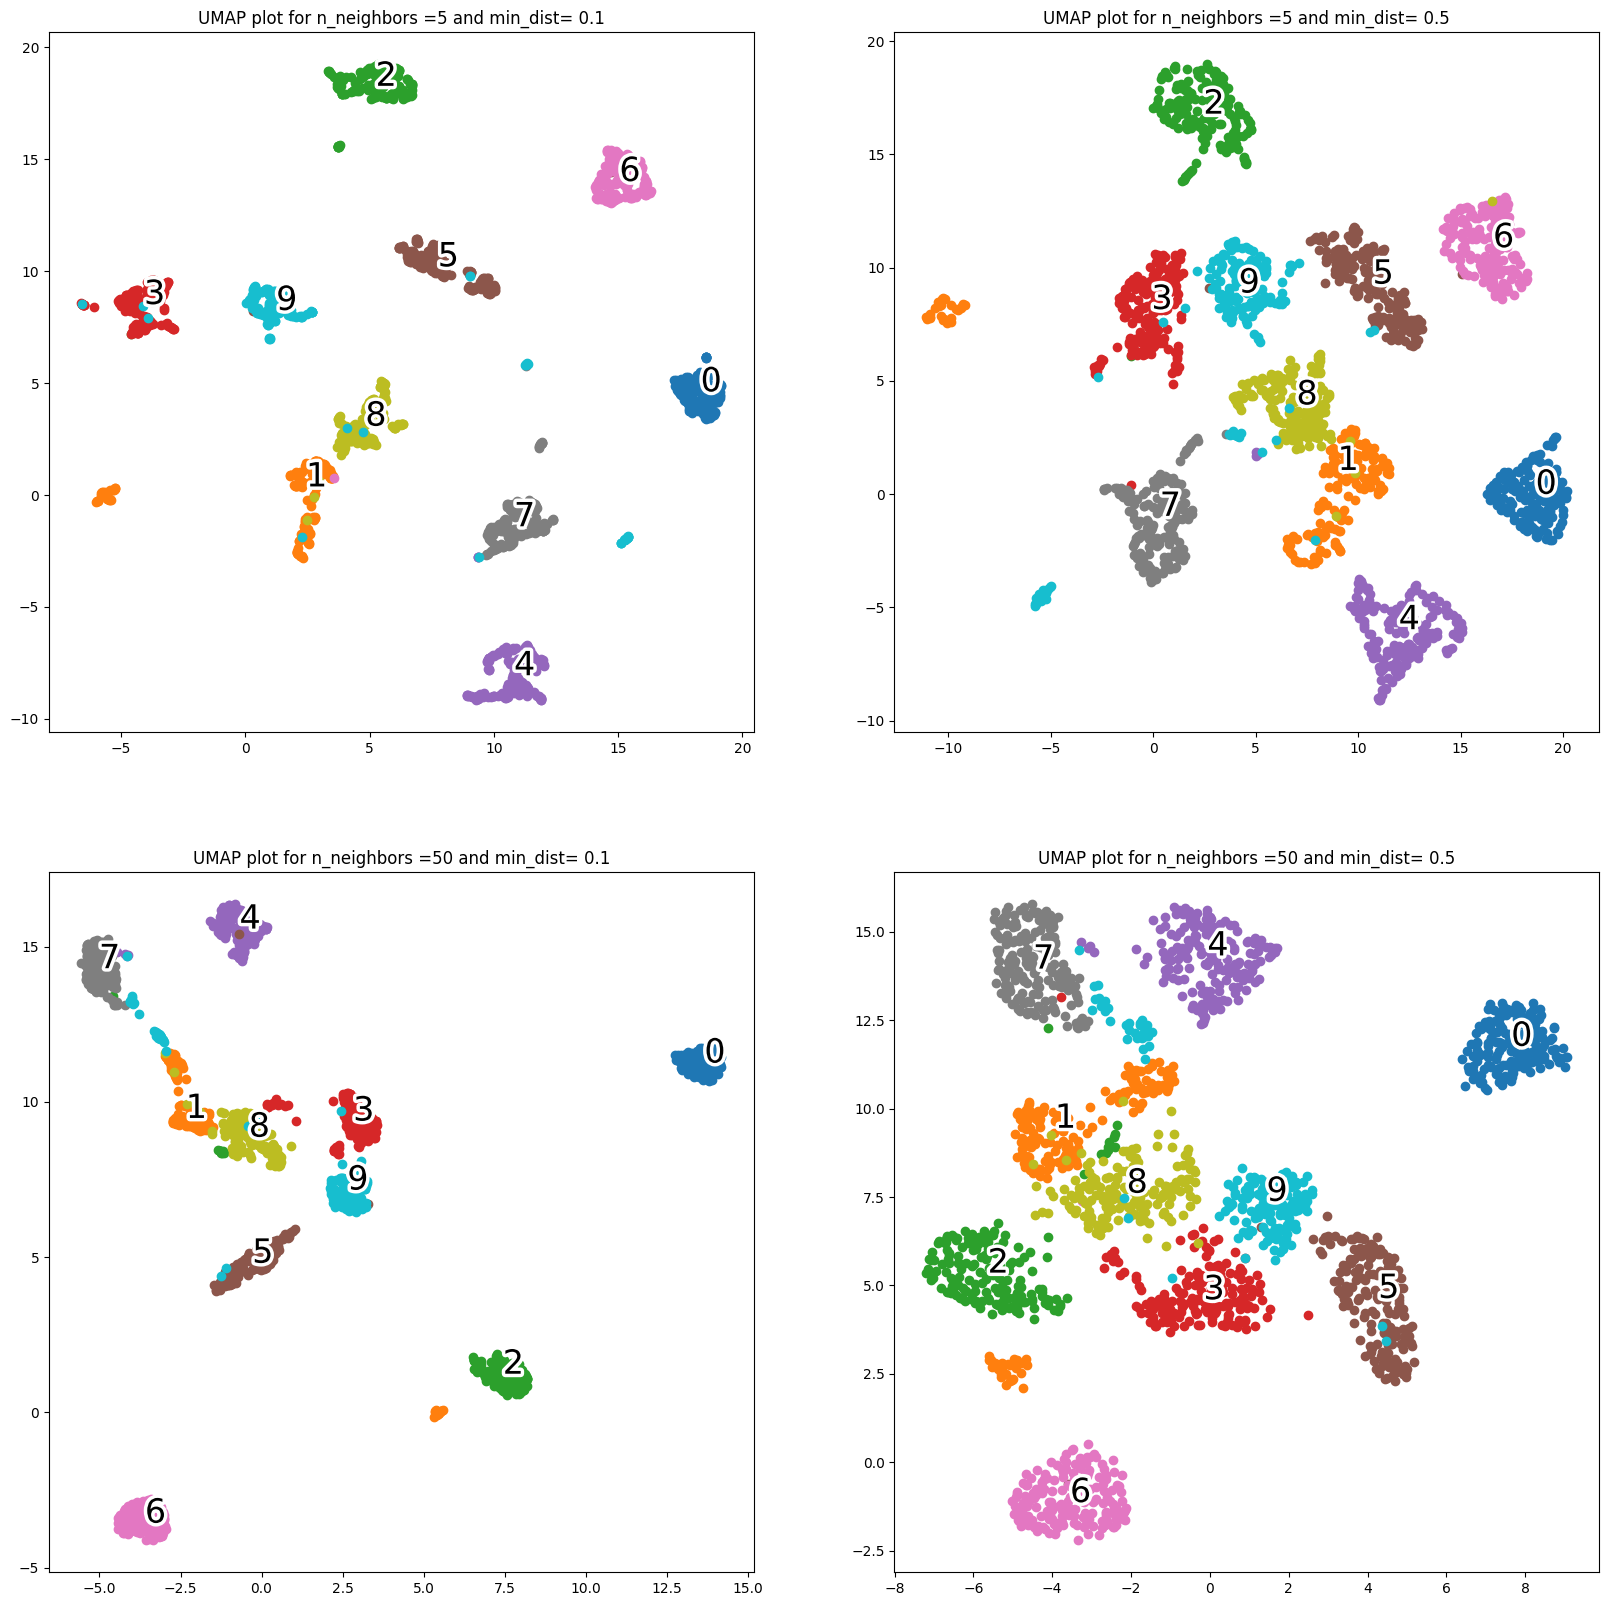

In [217]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for combs, ax in zip(combinations, axes.flat): 
    n_neighbors_value, min_dist_value =combs
    reducer =UMAP.UMAP(n_neighbors=n_neighbors_value, min_dist=min_dist_value)
    X_umap = reducer.fit_transform(digits.data)
    for i in range(10):
        ax.scatter(X_umap[y == i, 0], X_umap[y == i, 1])
        xtext, ytext = np.median(X_umap[y == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
    ax.set_title(f'UMAP plot for n_neighbors ={n_neighbors_value} and min_dist= {min_dist_value}')

UMAP also manages to create distinct clusters of digits based on how close are the points in the original space.
For lager value of *min_dist* we see more loose clusters. Low values of *n_neighbors* will force UMAP to concentrate on very local structure, while large values will push UMAP to look at larger neighborhoods of each point, losing fine detail structure for the sake of getting the broader of the data. Compared to TSNE, the clusters seem even more differentiated. 

## Practice question

Use Iris dataset and visualize it using PCA, TSNE, UMAP. Experiment with different values of the hyperparameters in TSNE and UMAP.